### Bixi use and gas prices: negative result

We tried to model how much Bixi use would change when gas prices changed, but we could not detect very much change based on the data we had.

#### Tool used

XGBoost.

#### Data sets

We spent a lot of time trying to get data sets, and eventually got:

- Gas price data set
- Bixi dataset
- Weather
- Cars waiting at intersections

The last data set turned out not to be useful for this purpose, because the intersection changed arbitrarily every day, so a fine-grained time-series comparison was not really possible. However, we used the first three to look for dependence of Bixi use on gas price, controlled by weather and time.

#### Explanation

We tried to analyse 2016-2017, which was available in both the Bixi dataset
and the gas price data set, but unfortunately there were no large gas price changes in that time.
The model was able to predict the Bixi use fairly well from time of day, weekday, temperature, and weather description (sunny, cloudy...), but it did not see much dependence on gas price.

In [ ]:
import numpy as np
import pandas
import datetime
import xgboost as xgb

from matplotlib import pyplot as p

reference_date = datetime.datetime(year = 2019, month = 1, day = 1)

def string_date_to_days(date):
    return (pandas.to_datetime(date) - reference_date) / np.timedelta64(1, 'D')
    
# numpy should show regular numbers with four digits after the period
np.set_printoptions(precision=4, suppress=True)

### Concat Bixi data

Here we create the array `bixi`.

`bixi[:, 0]` is the start time of a rental (in days since 2019 Jan 1)

`bixi[:, 1]` is the length of the corresponding rental (in hours)

In [202]:
# Collect the bixi data

FILES = [
    "OD_2014.csv",
    "OD_2015.csv",
    "OD_2016.csv",
    "OD_2017.csv"
]

bixifil = pandas.concat([pandas.read_csv(f) for f in FILES])

if True:
    def make_bixi():
        bixifil = pandas.concat([pandas.read_csv(f) for f in FILES])
        bixi = np.zeros((bixifil.shape[0], 2))
        bixi[:, 0] = string_date_to_days(bixifil['start_date'])
        #(pandas.to_datetime(bixifil['start_date']) -
        #              reference_date) / np.timedelta64(1, 'D')
        bixi[:, 1] = bixifil['duration_sec'] / 3600
        return bixi
else:
    def make_bixi():
        bixicsv = np.concatenate([
            pandas.read_csv(f).values for f in FILES
        ])

        bixi = np.zeros((bixicsv.shape[0], 2))

        for i in range(bixicsv.shape[0]):
            bixi[i, 0] = string_date_to_days(bixicsv[i, 1])

        bixi[:, 1] = bixicsv[:, 5]

        return bixi

bixi = make_bixi()

### Compute hourly usage of the Bixis

In [ ]:
OFFSET = 1722 * 24

def days_to_hourly_index(days):
    return days * 24 + OFFSET # should be rounded

def hourly_index_to_days(index):
    return (index - OFFSET) / 24

In [260]:
# This array will store the total number of minutes ridden during each hour.
# The 0th hour is April 15, 2014, 0:00
# (because that's when the first bike ride was)
# By the way, that is -1722 in our date format.

def buildhourly():
    total = 0
    hourly = np.zeros((1722 * 24,))
    for i in range(bixi.shape[0]):
        # convert start times to hours since 2014 April 15
        # (because that is when the dataset starts)
        start = bixi[i, 0] * 24 + OFFSET
        length = bixi[i, 1]
        total += length
        index = int(np.floor(start))
        nexthour = index + 1
        while start + length > nexthour:
            hourly[index] += nexthour - start
            length -= nexthour - start
            start = nexthour
            index += 1
            nexthour += 1
        hourly[index] += length
        if False: # debug
            if i % 1000000 ==0:
                print(i)
                print(total, np.sum(hourly))
    return hourly

bike_hourly_average = buildhourly()

In [480]:
bike_daily_average = np.mean(bike_hourly_average.reshape(-1, 24), axis=1)

In [482]:
bike_hourly_average.shape[0] - 1 - np.argmax(bike_hourly_average[::-1] > 0)

30360

### Collect temperature and weather data

In [335]:
ZERO_DEGREES_IN_KELVIN = 273.15

def buildtemperature():
    temperaturecsv = pandas.read_csv('../weather/temperature.csv')
    hours = string_date_to_days(temperaturecsv['datetime'])
    temperature = temperaturecsv['Montreal'].values - ZERO_DEGREES_IN_KELVIN
    return np.column_stack([hours, temperature])

temperature = buildtemperature()

# crop the array so it starts at April 15, 2016
# and matches up with the hourly array
cutoff = np.argmax(temperature[:, 0] + 1e-7 >= -1722)
temperature = temperature[cutoff:, :]
print("Date of first temperature:", temperature[0, 0])
print("Date of last temperature:", temperature[-1, 0])
last_temperature_date = temperature[-1, 0].astype(int)
temperature = np.concatenate([temperature[:, 1], np.full((-24*last_temperature_date-1,), np.nan)])
print(temperature.shape)

Date of first temperature: -1722.0
Date of last temperature: -397.0
(41328,)


In [389]:
def buildweatherdescription():
    weatherdescriptioncsv = pandas.read_csv('../weather/weather_description.csv')
    hours = string_date_to_days(weatherdescriptioncsv['datetime']).values
    desc = weatherdescriptioncsv['Montreal'].values
    weather_codes = list(
        sorted(set(desc) , key=lambda z: "" if type(z) == float else z )
    )
    reverse_weather_codes = {weather_codes[z]: z for z in range(len(weather_codes))}
    weather_description = np.zeros((desc.shape[0],), dtype=np.int)
    for i in range(desc.shape[0]):
        weather_description[i] = reverse_weather_codes[desc[i]]
    print("First hour:", hours[0])
    print("Last hour:", hours[-1])
    cutoff = np.argmax(hours + 1e-7 >= -1722)
    hours = hours[cutoff:]
    weather_description = weather_description[cutoff:]
    print("First hour:", hours[0])
    print("Last hour:", hours[-1])
    
    last_weather_description_date = hours[-1]
    padlength = -1 - 24*last_weather_description_date.astype(int)
    weather_description = np.concatenate([weather_description, np.full((padlength,), np.nan)])
    return weather_description, weather_codes, reverse_weather_codes

weather_description, weather_codes, reverse_weather_codes = buildweatherdescription()

First hour: -2282.5
Last hour: -397.0
First hour: -1722.0
Last hour: -397.0


In [390]:
weather_description.shape

(41328,)

In [357]:
code

{0: nan,
 1: 'broken clouds',
 2: 'drizzle',
 3: 'dust',
 4: 'few clouds',
 5: 'fog',
 6: 'freezing rain',
 7: 'haze',
 8: 'heavy intensity rain',
 9: 'heavy intensity shower rain',
 10: 'heavy shower snow',
 11: 'heavy snow',
 12: 'light intensity drizzle',
 13: 'light intensity drizzle rain',
 14: 'light intensity shower rain',
 15: 'light rain',
 16: 'light rain and snow',
 17: 'light shower sleet',
 18: 'light shower snow',
 19: 'light snow',
 20: 'mist',
 21: 'moderate rain',
 22: 'overcast clouds',
 23: 'proximity shower rain',
 24: 'proximity thunderstorm',
 25: 'sand',
 26: 'scattered clouds',
 27: 'shower drizzle',
 28: 'shower rain',
 29: 'shower snow',
 30: 'sky is clear',
 31: 'smoke',
 32: 'snow',
 33: 'thunderstorm',
 34: 'thunderstorm with heavy rain',
 35: 'thunderstorm with light rain',
 36: 'thunderstorm with rain',
 37: 'very heavy rain'}

### Collect gas prices (already prepared by extract.ipynb)

In [299]:
# gasprices[:, 0] is the time in days since 2019-01-01
# gasprices[:, 1] is the price in cents per litre
gasprices = np.loadtxt("../../nrcan.gc.ca/montreal.csv", delimiter=",", 
                       skiprows=1 )

In [300]:
# This one starts on July 1, 2016
print(gasprices[0, 0])
print(string_date_to_days('2016-07-01'))
def build_gasprices_extended():
    def run(gasprices):
        cutoff = np.argmax(gasprices[:, 0] >= 0)
        gasprices = gasprices[:cutoff, :]
        gasprices_extended_hourly = np.full((1722 * 24,), np.nan)
        start = gasprices[:, 0] * 24 + OFFSET
        start = np.round(start).astype(np.int)
        start = (start[:, None] + np.arange(24)[None, :])
        start = start.reshape(-1)
        gasprices_extended_hourly[start] = gasprices[:, 1].repeat(24)
        return gasprices_extended_hourly
    return run(gasprices)
    
gasprices_extended = build_gasprices_extended()

-914.0
-914.0


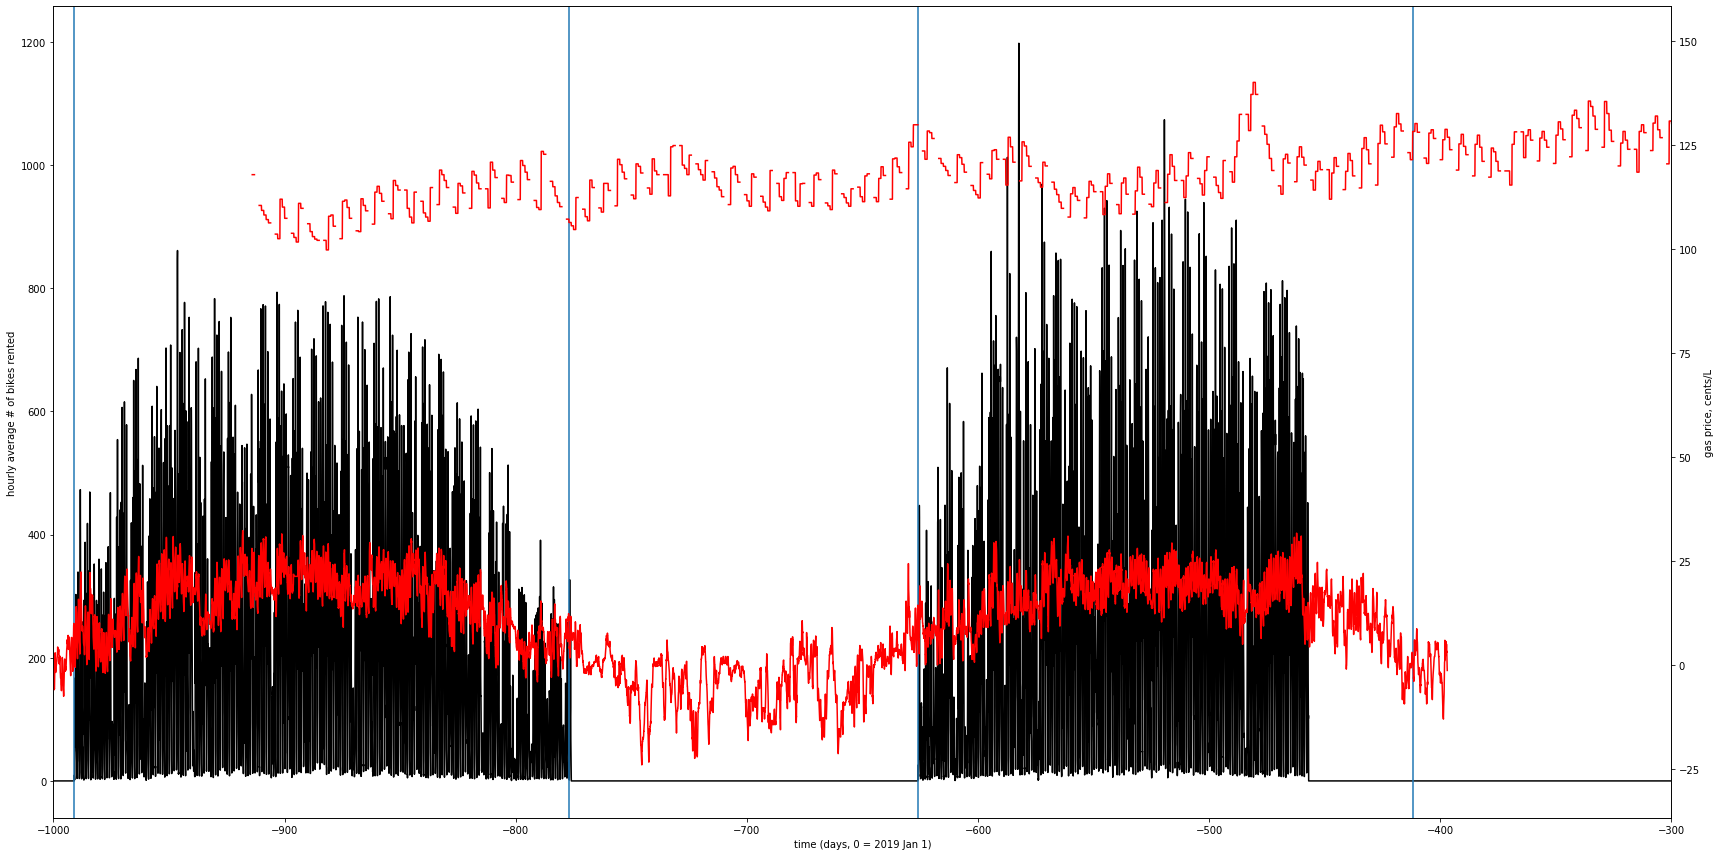

In [754]:
# plot everything with the horizontal axis of "days relative to 2019 Jan 1"

# the starts and ends of Bixi season (April 15 - Nov 15)
DATES = [
    "2014-04-15 00:00",
    "2014-11-15 00:00",
    "2015-04-15 00:00",
    "2015-11-15 00:00",
    "2016-04-15 00:00",
    "2016-11-15 00:00",
    "2017-04-15 00:00",
    "2017-11-15 00:00"
]

RANGE = np.arange(1722 * 24) / 24 - 1722

def makeplots():
    fig, ax1 = p.subplots(figsize = (24, 12))

    ax1.set_xlim([-1000, -300])
    COLOR = "black"
    ax1.set_xlabel('time (days, 0 = 2019 Jan 1)')
    ax1.set_ylabel('hourly average # of bikes rented')
    #ax1.plot(np.arange(1722) - 1722, bike_daily_average, color=COLOR)
    ax1.plot(RANGE, bike_hourly_average, color=COLOR)
    
    for index in [string_date_to_days(date) for date in DATES]:
        ax1.axvline(index)
    
    COLOR = "red"
    ax2 = ax1.twinx()
    ax2.set_ylabel('gas price, cents/L')
    ax2.plot(RANGE, gasprices_extended, color=COLOR)
    #ax2.plot(gasprices[:, 0], gasprices[:, 1], color=COLOR )
    #ax2.set_ylabel('temperature, C')
    ax2.plot(RANGE, temperature[:], color=COLOR)
    
    fig.tight_layout()
    
    fig.show()

makeplots()

In [682]:
def onehot(z, m):
    o = np.zeros((z.shape[0], m))
    offset = np.arange(z.shape[0]) * m
    if z.dtype == np.float64:
        notnan = np.logical_not(np.isnan(z))
        z = z[notnan].astype(int)
        offset = offset[notnan]
    np.put(o, z + offset, 1)
    return o

hour_of_day = np.tile(np.arange(24), 1722)

day_of_week = np.tile(np.array([4, 5, 6, 0, 1, 2, 3]).repeat(24), 246)

is_bixi_season = np.zeros((hour_of_day.shape[0]))
fn = lambda z: int(string_date_to_days(z) * 24 + OFFSET)
seasontimes = list(map(fn, ["2016-04-15", "2016-11-16", "2017-04-15", "2017-11-16"]))
for j in range(2):
    is_bixi_season[seasontimes[j*2+0]:seasontimes[j*2+1]] = 1

alldata = np.column_stack([
    onehot(hour_of_day, 24),
    onehot(day_of_week, 7),
    is_bixi_season,
    gasprices_extended,
    temperature,
    onehot(weather_description, 38),
    bike_hourly_average
])

CUTOFF = 30360 # this is where the bike data stops suddenly

alldata = alldata[:CUTOFF, :]

featurenames = [f"hour_{i}" for i in range(24)] + \
    [f"day_{i}" for i in range(7)] + \
    ["is_bixi_season", "gas_price", "temperature"] + \
    [f"weather_{i}" for i in range(38)]

In [684]:
# not sure how to do train-test split
# is it good enough to just randomly assign hours to train or test? probably not
# maybe break it down by week?
# try it with everything for now

unif = np.random.uniform(size=alldata.shape[0])
split = np.select([unif < 0.8, unif < 0.9, True], [0, 1, 2])
trainix, testix, validationix = split == 0, split == 1, split == 2
isbixi = alldata[:, featurenames.index("is_bixi_season")]
trainix, testix, validationix = [np.logical_and(z, isbixi)
    for z in (trainix, testix, validationix)]

def run_with_columns(columns):
    getmatrix = lambda z: xgb.DMatrix(alldata[z, :][:, columns], label=alldata[z, -1],
                                      feature_names=featurenames )
    train = getmatrix(trainix)
    test = getmatrix(testix)
    boost = xgb.train(
        {
            'tree_method': 'hist',
            'max_depth': 3,
            'objective': 'reg:squarederror'
        },
        train,
        2400
    )
    print(boost.eval(getmatrix(validationix)))
    print()
    score = boost.get_score(importance_type='gain')
    keys = sorted(score.keys(), key = lambda z: -score[z])
    print("Scores:")
    for z in keys:
        print("    %s: %f" % (z, score[z]))
    return boost

columns = list(range(72))
boost = run_with_columns(columns)

[0]	eval-rmse:68.195114

Scores:
    hour_4: 219980.419416
    hour_3: 207753.237109
    hour_5: 193306.452595
    hour_17: 172591.943060
    hour_2: 170278.426943
    hour_6: 149172.545243
    hour_1: 123929.953564
    hour_16: 117668.829621
    hour_18: 90502.702869
    hour_0: 74862.550568
    hour_8: 56121.312390
    day_2: 36934.718732
    hour_15: 35909.454205
    day_1: 34386.431739
    hour_23: 32714.601393
    hour_19: 32168.335489
    weather_15: 21971.357258
    hour_13: 21486.215752
    hour_14: 20328.146565
    temperature: 18834.497200
    hour_12: 17803.659926
    weather_20: 15576.781406
    hour_22: 15498.416000
    weather_4: 12211.801569
    hour_9: 11132.879469
    weather_21: 11000.396933
    weather_8: 9647.706941
    hour_21: 9599.178815
    weather_22: 9180.966931
    gas_price: 9037.143787
    hour_11: 8508.103569
    weather_30: 8413.307308
    hour_7: 7909.600716
    weather_1: 7539.241306
    hour_20: 7129.574599
    weather_14: 6921.258154
    day_3: 5969.3

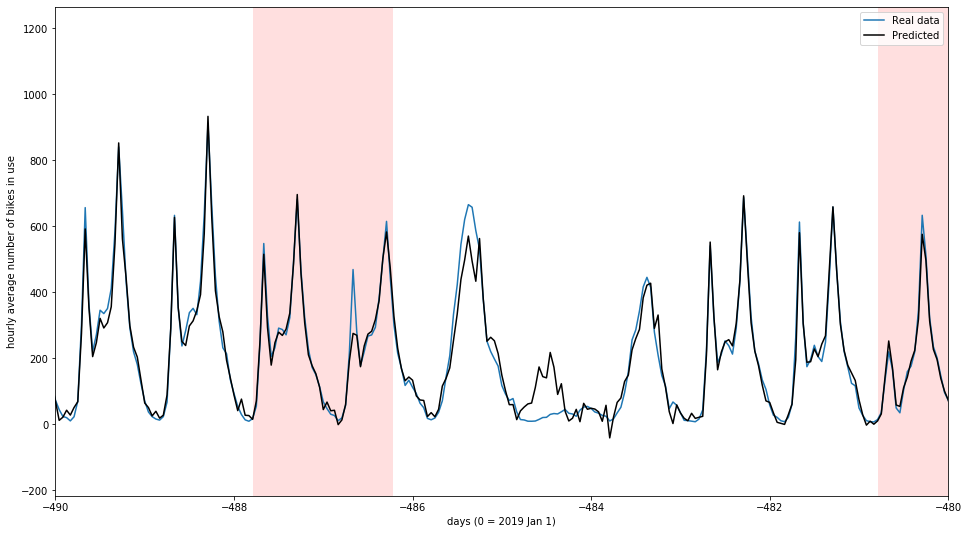

In [769]:
allofit = np.full((alldata.shape[0],), True)
o = boost.predict(getmatrix(allofit))
o *= isbixi

def plot(FROM, o, label, o2=None):
    p.figure(figsize=(16, 9))
    p.xlim([FROM, FROM+10])
    p.xlabel("days (0 = 2019 Jan 1)")
    p.ylabel("hourly average number of bikes in use")
    start = FROM * 24 + OFFSET
    nextsunday = RANGE[start + np.argmax(day_of_week[start: start+24*7 ] == 0)]
    for i in range(3):
        p.axvline(nextsunday, lw=140, color=(1, 14/16, 14/16) )
        nextsunday += 7
    p.plot(RANGE[:CUTOFF], bike_hourly_average[:CUTOFF], label="Real data")
    if o2 is not None:
        p.plot(RANGE[:CUTOFF], o2, color='red', label=label)
    else:
        p.plot(RANGE[:CUTOFF], o, color='black', label=label)
    p.legend()
    p.show()

plot(-490, o, "Predicted" )
# colored bars show the weekend
# (changing the scale will mess this up, sorry)

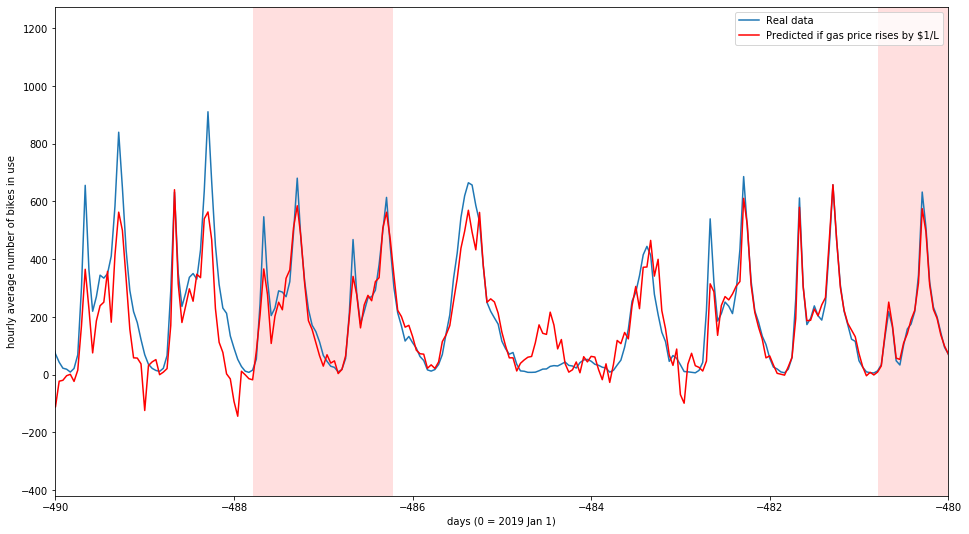

In [770]:
"""
# what if the gas price went up by 40 cents/litre?

gasindex = featurenames.index("gas_price")

gasprice = np.array([[40 if name == "gas_price" else 0 for name in featurenames]])

data = gasprice + alldata[:, 0:-1]

o2 = boost.predict(
    xgb.DMatrix(
        data,
        label=alldata[:, -1],
        feature_names=featurenames
    )
)

o *= isbixi
o2 *= isbixi
FROM = -490
# nya
p.figure(figsize=(24, 12))
p.xlim([FROM, FROM+10])
p.plot(RANGE[:CUTOFF], bike_hourly_average[:CUTOFF])
p.plot(RANGE[:CUTOFF], gasprices_extended[:CUTOFF])
p.plot(RANGE[:CUTOFF], o, color='black' )
p.plot(RANGE[:CUTOFF], o2, color='red')
p.show()
"""

# what if the gas price went up by 100 cents/litre?

gasindex = featurenames.index("gas_price")

gasprice = np.array([[100 if name == "gas_price" else 0 for name in featurenames]])

o2 = boost.predict(
    xgb.DMatrix(
        gasprice + alldata[:, 0:-1],
        label=alldata[:, -1],
        feature_names=featurenames
    )
)

o2 *= isbixi
plot(-490, o, "Predicted if gas price rises by $1/L", o2)